In [1]:
import sys
import pandas as pd
sys.path.append("..")
import seaborn as sns
import nltk

from humor.metric import fuzzy_match_metric
from humor.bipartite_metric import bipartite_metric

In [2]:
ground_truth = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_data.csv')
model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/gemma_answers.csv')
transcript = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_transcripts.csv')

In [3]:
#gemma
gemma_metric = bipartite_metric(model, ground_truth)

/home/ada/humor/notebooks/../humor/bipartite_metric.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


In [4]:
gemma_metric

,truth,score
0,"""Alright, you guys are all killing it academic...",0.000000
1,"""Because we don't say that when someone gives ...",0.000000
2,"""Click the links below, subscribe, leave a com...",0.000000
3,"""Does the front door not work?"" ""No, it works.",0.000000
4,"""Hi, everyone, same old me.""",0.000000
...,...,...
241,[audience cheers and applauds] He's a surfer. ...,0.206250
242,"[audience laughing] Very sorry, Radio City, di...",0.250000
243,[laughs] It just doesn't work. I remember when...,0.508333
244,[laughter] That kid won't choke on camera. He'...,0.018750


In [5]:
gemma_metric["score"].mean() * 100

2.9098915989159893

In [6]:
#Brute Force
brute_sentences = []
for i in range(len(transcript['comedian'])):
    comedian = transcript['comedian'][i]
    trans = transcript['transcript'][i]
    sentences = nltk.sent_tokenize(trans)
    for sentence in sentences:
        brute_sentences.append({'comedian': comedian, 'sentence': sentence})

In [7]:
brute_model = pd.DataFrame(brute_sentences)

In [8]:
brute = bipartite_metric(brute_model, ground_truth)

/home/ada/humor/notebooks/../humor/bipartite_metric.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


In [9]:
brute["score"].mean() * 100

2.050442924314776

In [10]:
#random
random_model = pd.read_csv("/home/ada/humor/data/stand_up_dataset/random_gemma_quotes.csv")
random = bipartite_metric(random_model, ground_truth)
random["score"].mean() * 100

1.8895663956639563

In [11]:
gemma = gemma_metric.assign(model="gemma") 
brute = brute.assign(model="brute") 
random = random.assign(model="random") 

In [12]:
df = pd.concat([gemma, brute, random]).reset_index(drop=True)

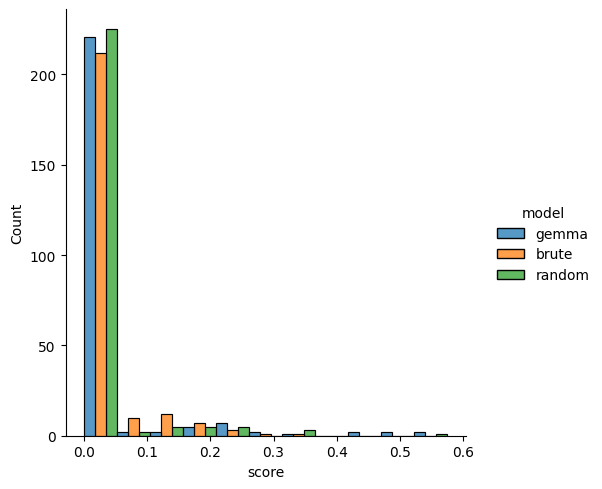

In [13]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

In [15]:
phi_model = pd.read_csv("/home/ada/humor/data/stand_up_dataset/phi3_mini_quotes.csv")
phi_metric = bipartite_metric(phi_model, ground_truth)
phi_metric["score"].mean() * 100

/home/ada/humor/notebooks/../humor/bipartite_metric.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


2.1959688346883466

In [16]:
phi = phi_metric.assign(model="phi") 

In [21]:
llm = pd.concat([gemma, phi, brute]).reset_index(drop=True)

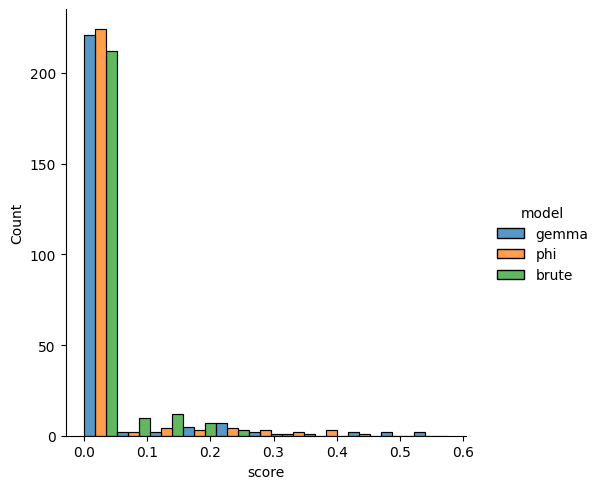

In [22]:
sns.displot(llm, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")